<img src="img/mvp_art.png" width=200 height=200 />

# Predicting the NBA's Most Valuable Player
#### John Newhagen, Rahul Reddy, & Austin Smith
---

### Project Description:
For this Data Science tutorial, we will be following the "Data Cycle" in order to generate a model for predicting future NBA Most Valuable Player (MVP) award winners. By the end of this tutorial, we will have covered a combination of basic and advanced skills required for collecting, visualizing, interpreting, and communicating data.

The first step in our process will be collecting data on past MVP winners and their statistics. Once we have this data, we must first tidy and clean our tables so that they are easy to work with and display. Next, we can use our tidy tables to analyze and visualize trends among NBA MVP award winners. After this, we will be able to train our model for predicting MVP winners. Finally, we will test our model on the current NBA season to predict the 2020 NBA MVP.

Data Sources: https://www.basketball-reference.com/, https://basketball.realgm.com/

#### What is the NBA?:
The National Basketball Association (NBA) is a Men's Professional Basketball League within North America, consisting of twenty-nine teams from the United States, and one team from Canada. Originally founded in 1946, the NBA is widely regarded as the pioneer of basketball among all leagues across the world. As a result, many international players come to the NBA to play basketball for one of these thirty teams, hailing primarily from Spain, Australia, and other Eastern European countries.

To summarize an NBA basketball game, each game game consists of four, twelve minute quarters to play against each other. The team that has scored the most points at the end of the game through either two-pointers, three-pointers, or free throws is rewarded with one win out of a possible 82 in a single season. We will be focusing on these 82 games and ignoring playoff games as the MVP is selected before the post-season.

If you would like to learn about the basics of basketball, see [here](https://www.breakthroughbasketball.com/basics/basics.html)

#### Who is the MVP?:
At the end of the regular season, NBA media members receive the opportunity to vote for the MVP. They have five votes to give out, and select their first through fifth choice selections when they vote. The order in which the select their MVP candidates determines how many points the player receives in the MVP race and the player with the most voting points wins the Most Valuable Player award.

For more information on how the MVP is selected, see [here](https://thenewdaily.com.au/sport/basketball/2018/03/29/nba-mvp-award/)
___

### Importing Packages
Before we can begin collecting our data, we must import the packages that will be used throughout the project.
* [os](https://docs.python.org/3/library/os.html) will allow us to interact with our local files
* [pandas](https://pandas.pydata.org/pandas-docs/stable/) and [numpy](https://docs.scipy.org/doc/numpy/user/) which will allow us to properly clean and display our tabular data
* [matplotlib](https://matplotlib.org/contents.html) and [seaborn](https://seaborn.pydata.org/) will be used for plotting our data
* [Scikit-Learn](https://scikit-learn.org/stable/index.html) will be used to create a model from our data

In [1]:
# Enter into terminal to update website: jupyter nbconvert --to html index.ipynb
# File-handling package
import os
# Web-scraping and Data-handling packages
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import unidecode as uni
# Plotting packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
register_matplotlib_converters()
import seaborn as sns
sns.set(style="darkgrid")
# Regression Modeling and Testing packages
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

### Finding MVP Candidates
---
The first step in our process is determining who has won the NBA's Most Valuable player award and who the candidates for MVP have been since the 2000-01 NBA season. This cutoff was used as the NBA and basketball have changed over the years so constraining our data to the most recent 18 seasons should allow us to account for some of the changes while still collecting enough data to create a realistic model of MVP Voting Share.

First we create two functions that will allow us to modify and tidy the table we will be scraping from [basketball-reference](https://www.basketball-reference.com/).

In [2]:
# This function takes a pandas dataframe and renames all unnamed levels to remove them from the table
# Returns the rennamed dataframe
def rename_unnamed(df):
    for i, columns in enumerate(df.columns.levels):
        columns_new = columns.tolist()
        for j, row in enumerate(columns_new):
            if 'Unnamed: ' in row:
                columns_new[j] = ''
        df = df.rename(columns=dict(zip(columns.tolist(), columns_new)), level=i)
    return df
# This fuction takes a pandas dataframe and collapses the columns of a MultiIndexed pandas dataframe
# Returns the collapsed dataframe
def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: ''.join(x))
    return df

Now that we have those, we can proceed by creating a dataframe containing the top 5 MVP candidates from 2001 to 2019 and their MVP Rank and Voting Share.

MVP Rank represents their position in the MVP race, while Voting Share represents the percent of the total amount of possible votes they received. We are using Voting Share instead of Voting Points because the maximum possible votes changes from season to season depending on how many media members are selected to vote for MVP.

We use pandas to obtain the table containing our data, then we modify the table using the functions declared above, and finally we select the columns we want and add them to the votes dataframe.

In [3]:
votes_df = pd.DataFrame()
for year in range(2001,2020):
    data = pd.read_html('https://www.basketball-reference.com/awards/awards_' + str(year) + '.html')[0]
    data = collapse_columns(rename_unnamed(data))
    data['Year'] = year # add a column to show the year associated with each entry in the dataframe
    votes_df = votes_df.append(data.loc[:4, ['Year', 'Rank', 'Player', 'Tm', 'VotingShare']])
# a weird error with some values being interpreted as ints and others as strings means we must cast out Rank column
# to ints
votes_df['Rank'] = votes_df['Rank'].astype(int)
votes_df.head(10)

Year  Rank            Player   Tm  VotingShare
0  2001     1     Allen Iverson  PHI        0.904
1  2001     2        Tim Duncan  SAS        0.569
2  2001     3  Shaquille O'Neal  LAL        0.466
3  2001     4      Chris Webber  SAC        0.420
4  2001     5     Kevin Garnett  MIN        0.122
0  2002     1        Tim Duncan  SAS        0.757
1  2002     2        Jason Kidd  NJN        0.712
2  2002     3  Shaquille O'Neal  LAL        0.552
3  2002     4     Tracy McGrady  ORL        0.310
4  2002     5       Kobe Bryant  LAL        0.078

Before we move on to the next step, we will attempt our first data visualization by using a seaborn scatterplot to display the Voting Shares of the top 5 MVP candidates in each season.

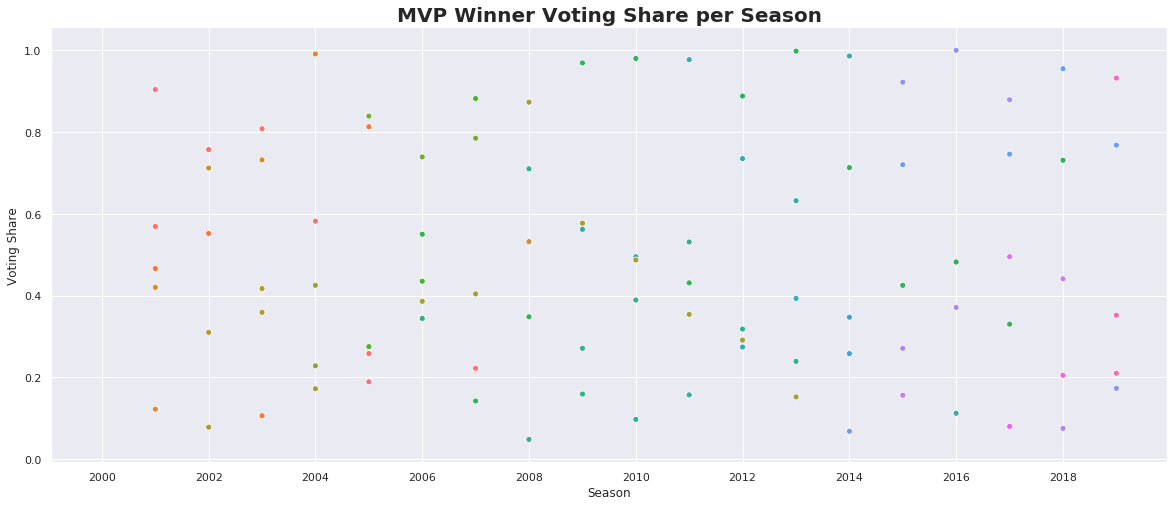

In [4]:
# create a column containing years as datetime values for better graphing, this column will not be used anywhere 
# else in the tutorial so it is removed at the end of this code block
votes_df['Year_DT'] = [pd.to_datetime(x, format='%Y') for x in votes_df['Year']] 
plt.figure(figsize=(20,8))
p = sns.scatterplot(x='Year_DT',y='VotingShare', hue='Player', data=votes_df, legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('MVP Winner Voting Share per Season', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Voting Share')
plt.show()
votes_df.drop(columns='Year_DT', inplace=True)

### Building the MVP Candidate Statistics Dataset
---

Now that we have a list of MVP candidates and their voting shares, we want to collect some statistics for all of our MVP candidates.

We will be collecting data in terms of three separate metrics: 
* Per-Game statistics
* Team statistics
* Contribution statistics (Per-Game/Team)

As before, we begin by declaring several useful functions that will be used to collect and clean our data.

In [5]:
# This function takes a player name and identifying number and converts the name into the format required for a
# basketball-reference player page
def normalize(name, j):
    return str.lower(name.split()[1])[:1] + '/' + \
                uni.unidecode(str.lower(name.split()[1]).replace("'", "").replace('-',''))[:5] + \
                                str.lower(name.split()[0]).replace("'", "").replace('.','')[:2] + '0' + str(j)

# This function takes a row of player statistics and adds relevant information
def tabulate(row, name, year, i):
    row['Name'] = name
    if name in list(votes_df[votes_df['Year'] == year]['Player']):
        row['VotingShare'] = votes_df[votes_df['Year'] == year]['VotingShare'][i]
        row['Rank'] = votes_df[votes_df['Year'] == year]['Rank'][i]
    row.replace(np.nan, 0, inplace=True) # replace any missing values with 0
    return row

# This function takes a list of players and their teams and collects data on their per-game and team statistics
# for the given year
# Returns per-game and team statistics
def collect(players, teams, year, pg, tm):
    i = 0
    for (name, team_name) in zip(players, teams):
        # construct the link for the page corresponding to the given player name
        link = 'https://www.basketball-reference.com/players/' + normalize(name, 1) + '.html'
        # if a player's normalized name is the same as a player who joined the league before them, then their
        # page will be identified with a number greater than 1, so we search until we find that page
        j = 2
        season = str(str(year-1) + '-' + str(year)[2:])
        while season not in list(pd.read_html(link)[0]['Season']):
            link = 'https://www.basketball-reference.com/players/' + normalize(name, j) + '.html'
            j += 1
        
        # collect per-game stats
        pergame = pd.read_html(link)[0]
        if pergame['3P%'].isnull().any():
            pergame.drop(columns='3P%',inplace=True)
        pergame.dropna(inplace=True)
        pergame['Season'] = [int(str(x).split('-')[0])+1 for x in pergame['Season']]
        pergame = pergame[pergame['Season'] == year] # isolate the MVP candidate season
        pergame.reset_index(inplace=True,drop=True)
        # select our desired statistics
        pergame = pergame.reindex(columns=['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST',
                                           'STL', 'BLK', 'TOV', 'FG%', '3P%', 'eFG%', 'FT%'])
        # convert all relevant statistics to float values
        for col in ['G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%',
                    'eFG%', 'FT%']:
            pergame[col] = pergame[col].astype(float)
        pg = pg.append(tabulate(pergame, name, year, i), ignore_index=True)

        # Several team names have changed over the years so a conversion to the correct team ID is needed
        if team_name == 'NOP': 
            team_name = 'NOH'
        elif team_name == 'BRK': 
            team_name = 'NJN'
        elif team_name == 'CHO':
            team_name = 'CHA'
        elif team_name == 'PHX':
            team_name = 'PHO'
        # collect team stats
        team = pd.read_html('https://www.basketball-reference.com/teams/' + team_name + \
                            '/stats_per_game_totals.html')[0]
        # need to convert the entries in the Season column into a year that can be compared with our given value
        team.replace('Season', '0000-00', inplace=True)
        team['Season'] = [int(str(x).split('-')[0])+1 for x in team['Season']]
        team = team[team['Season'] == year] # isolate the MVP candidate season
        team['Win_Pct'] = team['W'].astype(int)/team['G'].astype(int) # calculate win-percentage
        # select our desired statistics
        team = team.reindex(columns=['Season', 'Tm', 'Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 
                                       'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%'])
        # convert all relevant statistics to float values
        for col in ['Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%']:
            team[col] = team[col].astype(float)
        tm = tm.append(tabulate(team, name, year, i), ignore_index=True)
        i += 1
    return (pg, tm)

Using these functions, we can scrape the basketball-reference database for the statistics that we need.

We will be scraping a lot of data from basketball-reference, which is not a quick process, so, once we have our data, we save our tables as local files that we can then access in the future without having to scrape all the data again.

In [6]:
if not(os.path.isfile('PerGame.csv')): # check if data has already been scraped
    pg = pd.DataFrame()
    tm = pd.DataFrame()
    # This loop collects per-game and team statistics for all MVP candidates from 2001 to 2019
    for year in range(2001,2020):
        (pg, tm) = collect(votes_df[votes_df['Year'] == year]['Player'], votes_df[votes_df['Year'] == year]['Tm'], 
                           year, pg, tm)
    pg.to_csv('PerGame.csv')
    tm.to_csv('Team.csv')

pg = pd.read_csv('PerGame.csv').drop(columns=['Unnamed: 0']) # to_csv() adds an extra column that we will drop
tm = pd.read_csv('Team.csv').drop(columns=['Unnamed: 0'])

Now that we have our data and it has been cleaned, we will take a look at our per-game and team statistics for each player.

In [7]:
# Per Game Statistics
pg.head(10)

Season   Tm Pos     G    MP   PTS  ORB  DRB   TRB  AST  STL  BLK  TOV  \
0    2001  PHI  SG  71.0  42.0  31.1  0.7  3.1   3.8  4.6  2.5  0.3  3.3   
1    2001  SAS  PF  82.0  38.7  22.2  3.2  9.0  12.2  3.0  0.9  2.3  3.0   
2    2001  LAL   C  74.0  39.5  28.7  3.9  8.8  12.7  3.7  0.6  2.8  2.9   
3    2001  SAC  PF  70.0  40.5  27.1  2.6  8.5  11.1  4.2  1.3  1.7  2.8   
4    2001  MIN  PF  81.0  39.5  22.0  2.7  8.7  11.4  5.0  1.4  1.8  2.8   
5    2002  SAS  PF  82.0  40.6  25.5  3.3  9.4  12.7  3.7  0.7  2.5  3.2   
6    2002  NJN  PG  82.0  37.3  14.7  1.6  5.7   7.3  9.9  2.1  0.2  3.5   
7    2002  LAL   C  67.0  36.1  27.2  3.5  7.2  10.7  3.0  0.6  2.0  2.6   
8    2002  ORL  SG  76.0  38.3  25.6  2.0  5.9   7.9  5.3  1.6  1.0  2.5   
9    2002  LAL  SG  80.0  38.3  25.2  1.4  4.1   5.5  5.5  1.5  0.4  2.8   

     FG%    3P%   eFG%    FT%              Name  VotingShare  Rank  
0  0.420  0.000  0.447  0.814     Allen Iverson        0.904     1  
1  0.499  0.259  0.502  0.618        Tim Duncan        0.569     2  
2  0.572  0.000  0.572  0.513  Shaquille O'Neal        0.466     3  
3  0.481  0.000  0.481  0.703      Chris Webber        0.420     4  
4  0.477  0.000  0.484  0.764     Kevin Garnett        0.122     5  
5  0.508  0.100  0.508  0.799        Tim Duncan        0.757     1  
6  0.391  0.000  0.442  0.814        Jason Kidd        0.712     2  
7  0.579  0.000  0.579  0.555  Shaquille O'Neal        0.552     3  
8  0.451  0.000  0.483  0.748     Tracy McGrady        0.310     4  
9  0.469  0.250  0.479  0.829       Kobe Bryant        0.078     5

In [8]:
# Team Statistics
tm.head(10)

Season   Tm   Win_Pct    PTS   ORB   DRB   TRB   AST  STL  BLK   TOV  \
0    2001  PHI  0.682927   94.7  13.1  31.7  44.8  20.6  8.4  5.0  15.8   
1    2001  SAS  0.707317   96.2  11.0  33.1  44.1  21.7  6.9  7.0  14.0   
2    2001  LAL  0.682927  100.6  13.2  31.5  44.7  23.0  6.9  6.0  14.4   
3    2001  SAC  0.670732  101.7  12.0  33.0  45.0  22.6  9.7  5.3  14.9   
4    2001  MIN  0.573171   97.3  12.2  30.1  42.3  25.4  8.3  5.6  13.9   
5    2002  SAS  0.707317   96.7  11.1  31.3  42.4  20.0  7.6  6.5  14.4   
6    2002  NJN  0.634146   96.2  12.7  30.7  43.3  24.3  8.7  6.0  14.5   
7    2002  LAL  0.707317  101.3  12.5  31.8  44.3  23.0  7.6  5.8  12.7   
8    2002  ORL  0.536585  100.5  11.5  29.8  41.2  22.0  8.1  4.7  13.6   
9    2002  LAL  0.707317  101.3  12.5  31.8  44.3  23.0  7.6  5.8  12.7   

     FG%    3P%    FT%              Name  VotingShare  Rank  
0  0.447  0.326  0.745     Allen Iverson        0.904     1  
1  0.461  0.407  0.715        Tim Duncan        0.569     2  
2  0.465  0.344  0.683  Shaquille O'Neal        0.466     3  
3  0.449  0.354  0.771      Chris Webber        0.420     4  
4  0.458  0.357  0.785     Kevin Garnett        0.122     5  
5  0.458  0.362  0.742        Tim Duncan        0.757     1  
6  0.446  0.338  0.735        Jason Kidd        0.712     2  
7  0.461  0.354  0.699  Shaquille O'Neal        0.552     3  
8  0.448  0.373  0.754     Tracy McGrady        0.310     4  
9  0.461  0.354  0.699       Kobe Bryant        0.078     5

For our third metric, we will determine each player's contributions to their team's total statistics by dividing their per-game statistics by their team's statistics.

In [9]:
# Contribution Statistics
ctb = pd.DataFrame()
ctb['Season'] = pg['Season']
ctb['Tm'] = pg['Tm']
for col in ['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV']:
    ctb[str(col+'_CTB')] = pg[col]/tm[col]
ctb['Name'] = pg['Name']
ctb['VotingShare'] = pg['VotingShare']
ctb['Rank'] = pg['Rank']
ctb.head(10)

Season   Tm   PTS_CTB   ORB_CTB   DRB_CTB   TRB_CTB   AST_CTB   STL_CTB  \
0    2001  PHI  0.328405  0.053435  0.097792  0.084821  0.223301  0.297619   
1    2001  SAS  0.230769  0.290909  0.271903  0.276644  0.138249  0.130435   
2    2001  LAL  0.285288  0.295455  0.279365  0.284116  0.160870  0.086957   
3    2001  SAC  0.266470  0.216667  0.257576  0.246667  0.185841  0.134021   
4    2001  MIN  0.226105  0.221311  0.289037  0.269504  0.196850  0.168675   
5    2002  SAS  0.263702  0.297297  0.300319  0.299528  0.185000  0.092105   
6    2002  NJN  0.152807  0.125984  0.185668  0.168591  0.407407  0.241379   
7    2002  LAL  0.268509  0.280000  0.226415  0.241535  0.130435  0.078947   
8    2002  ORL  0.254726  0.173913  0.197987  0.191748  0.240909  0.197531   
9    2002  LAL  0.248766  0.112000  0.128931  0.124153  0.239130  0.197368   

    BLK_CTB   TOV_CTB              Name  VotingShare  Rank  
0  0.060000  0.208861     Allen Iverson        0.904     1  
1  0.328571  0.214286        Tim Duncan        0.569     2  
2  0.466667  0.201389  Shaquille O'Neal        0.466     3  
3  0.320755  0.187919      Chris Webber        0.420     4  
4  0.321429  0.201439     Kevin Garnett        0.122     5  
5  0.384615  0.222222        Tim Duncan        0.757     1  
6  0.033333  0.241379        Jason Kidd        0.712     2  
7  0.344828  0.204724  Shaquille O'Neal        0.552     3  
8  0.212766  0.183824     Tracy McGrady        0.310     4  
9  0.068966  0.220472       Kobe Bryant        0.078     5

### Visualization
---
Now that we have collected and cleaned our data, we will begin the Exploratory Data Analysis step by displaying and analyzing several statistics.

We have isolated the statistics of our MVP winners to show the relationship between MVP winner statistics and Voting Share.

Our first plot will display MVP points per game versus voting share.

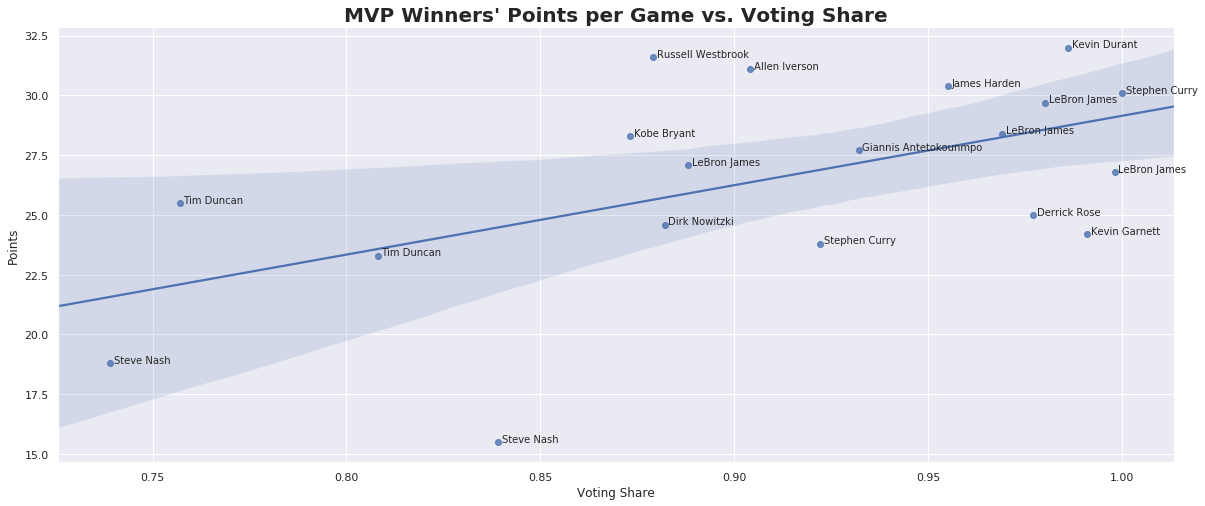

In [12]:
# select only MVP winners for each dataset
mvp_pg = pg[pg['Rank'] == 1]
mvp_tm = tm[tm['Rank'] == 1]
mvp_ctb = ctb[ctb['Rank'] == 1]

plt.figure(figsize=(20,8))
p = sns.regplot(x='VotingShare',y='PTS',data=mvp_pg) # scatter plot with regression line
plt.title('MVP Winners\' Points per Game vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Points')
# annotate plot; adapted from: https://stackoverflow.com/questions/15910019/annotate-data-points-while-plotting
# -from-pandas-dataframe
for index, row in mvp_pg.iterrows():
    plt.annotate("".join(mvp_pg['Name'][index]), xy = (mvp_pg['VotingShare'][index] + 0.001, mvp_pg['PTS'][index]))
plt.show()

As shown above, the graph depicts the relationship between MVP winners' points per game and voting share. The graph appears to show a positive relationship between the two which indicates a general tendency where players who score more points have a higher voting share. When comparing the players to the general trend we noticed that there is one major outlier, Steve Nash. Overall, the average points per game was 26.521 points. The highest points scored by an individual player was Kevin Durant with 32 points. The lowest points scored by an individual player was Steve Nash with 15.5 points.

Our next plot will show MVP team's winning percentage versus voting share.

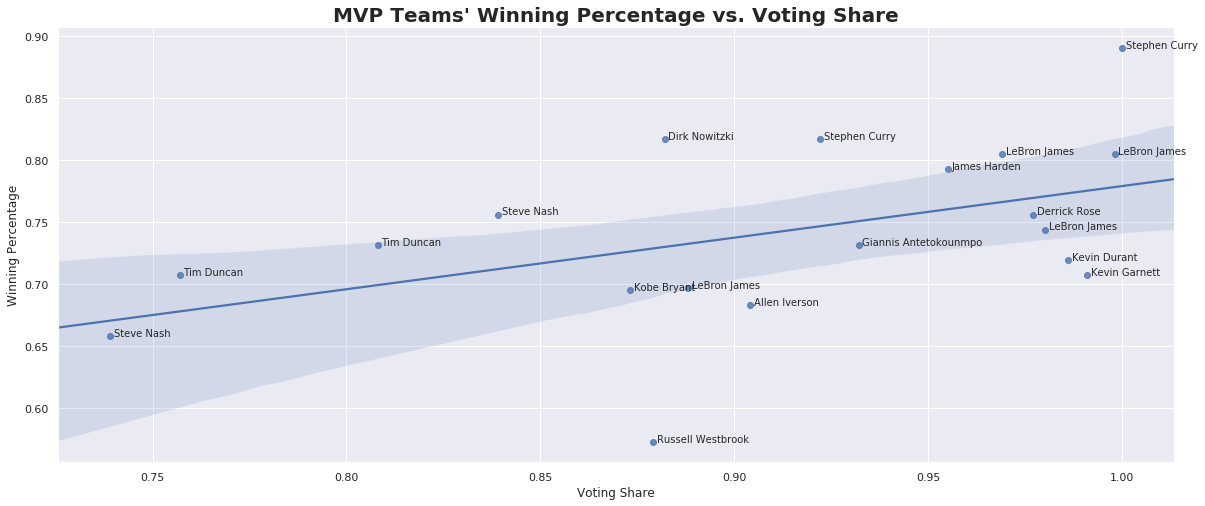

In [13]:
plt.figure(figsize=(20,8))
p = sns.regplot(x='VotingShare',y='Win_Pct',data=mvp_tm)
plt.title('MVP Teams\' Winning Percentage vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Winning Percentage')
for index, row in mvp_tm.iterrows():
    plt.annotate("".join(mvp_tm['Name'][index]), xy = (mvp_tm['VotingShare'][index] + 0.001, 
                                                       mvp_tm['Win_Pct'][index]))
plt.show()

In the graph above, we show the relationship between voting share and the winning percentage of MVP winners' teams. It appears that there is also a positive relationship between the voting share and the winning percentage of players which indicates that players whose team have a high winning percentage tend to have a high voting share. There are some notable outliers in the graph, one being Russell Westbrook's Oklahoma City Thunder who had a winning percentage of 57.3%. The other notable outlier is Stephen Curry's Golden State Warriors with a winning percentage of 89.0%. Overall, the average winning percentage among all MVP's teams was 74.1%.

Our final plot will show MVP turnover contribution versus voting share.

*Note on turnovers:* As turnovers count the number of times a player has lost the ball or had the ball stolen by an opponent, it might seem counterintuitive to look for a relationship between turnovers and voting share. However, one fact that must be considered is that star players possess the ball more often than their teammates, so they inevitably lose the ball throughout the course of a game. So, although they may be better at not turning the ball over than other players, their turnover count is still high due to their high usage rate. So, we will treat the relationship between turnovers and voting share as a factor of usage rate rather than as a sign of a bad player.

For more information on usage rate, see [here](https://rotogrinders.com/lessons/what-is-usage-rate-919038)

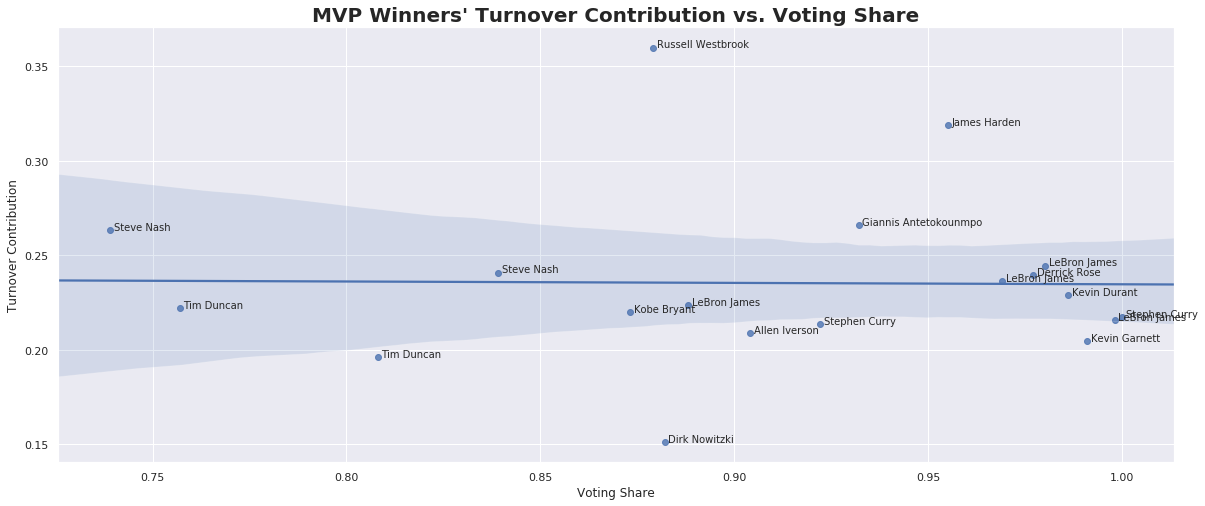

In [14]:
plt.figure(figsize=(20,8))
p = sns.regplot(x='VotingShare',y='TOV_CTB',data=mvp_ctb)
plt.title('MVP Winners\' Turnover Contribution vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Turnover Contribution')
for index, row in mvp_ctb.iterrows():
    plt.annotate("".join(mvp_ctb['Name'][index]), xy = (mvp_ctb['VotingShare'][index] + 0.001, 
                                                        mvp_ctb['TOV_CTB'][index]))
plt.show()

In this graph above, we show the relationship between MVP candidates' turnover contribution and their voting share. This graph shows no positive relationship between turnover contribution and voting share. There are some notable outliers in the graph, one being Russell Westbrook, with 36% of his team's turnovers, and  Dirk Nowitzki, with 15.1079% of his team's turnovers. Overall, the average percentage of assist contribution by and MVP candidate was 23.534%.

### MVP Positions
For our next data visualization, we will be looking at the positions of MVP candidates to see if we can find any trends.

There are five main player positions in basketball: Center (C), Power Forward (PF), Small Forward (SF), Shooting Guard (PG), and Point Guard (PG). A brief description of each type of player is described below:

Point Guard (PG):

    Typically the shortest player on the team
    Responsible for offensive advancement across the basketball court and usually has the best dribbling and passing abilities.

Shooting Guard (SG):

    Typically one of the shorter players on the team
    Can shoot midrange, three-pointers, and close shots (think of this as an All-Round great shooter).

Small Forward (SF):

    Most versatile of the five positions
    Typically long and athletic, which allows them to be regarded as one of the best defensive positions.

Power Forward (PF):

    Typically the second tallest player on the team
    Plays close to the rim and score most points inside the three-point arch.

Center (C):

    Tallest and strongest player on the team
    Stays close to the rim both on offense and defense to score close-range points (usually in the form of layups and dunks).

[Source](https://www.basketballforcoaches.com/basketball-positions/)

The visual below might provide further insight:

<img src="img/shooting_positions.png" width=300 height=300 />


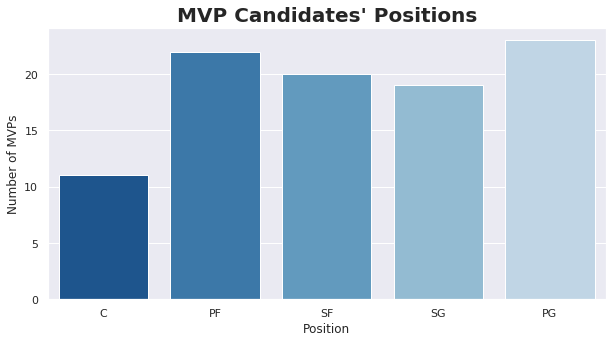

In [15]:
# count the number of MVP Candidates per position
pos_map = {'C': 0, 'PF': 0, 'SF': 0, 'SG': 0, 'PG': 0}
for p in list(pg['Pos']):
    pos_map[p] += 1
pos = pd.DataFrame([pos_map]).melt()
plt.figure(figsize=(10,5))
p = sns.barplot(x='variable',y='value',data=pos, palette=sns.color_palette('Blues_r'))
plt.title('MVP Candidates\' Positions', fontweight="bold", fontsize=20)
plt.xlabel('Position')
plt.ylabel('Number of MVPs')
plt.show()

Over the last 18 seasons, 22 of the MVP candidates have been Power Forwards (PF), 23 have been Point Guards (PG), 20 have been Small Forwards (SF), 19 have been Shooting Guards (SG), and 11 have been Centers (C). This data shows that MVP candidates typically are not Centers, and are most likely to be Power Forwards or Point Guards.

### Finding Correlations
Our next step in data analysis and visualization is calculating and displaying correlations between the statistics we have collected and the voting share of each MVP candidate.

We will find the correlations of per-game, team, and contribution statistics with voting share in order to determine the relevant variables that we will want to include in our MVP prediction model.

For the heat maps displayed below, we highlight the statistics with the highest correlation with voting share.

First, we declare a function that will allow us to create heatmaps of the correlations we find.

In [16]:
# This function takes a dataframe and a list of columns to be treated as variables; finds the correlation between
# all variables and isolates the correlations of the variables with voting share, then generates a heatmap of the
# correlations
def hmap(df, variables):
    corr = df.corr()[variables] # finds correlations and selects relevant columns
    corr = corr.take([len(df.corr())-1]) # selects the VotingShare row
    plt.figure(figsize=(20,8))
    ax = plt.gca()
    sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
    plt.yticks(rotation=0)
    return plt

Our first heat map will show the correlations between per-game statistics and voting share. It is important to note that none of the correlations were particularly strong, so we highlighted the statistics with the highest correlation because although they are weak correlations they have a stronger relationship than the rest of the statistics.

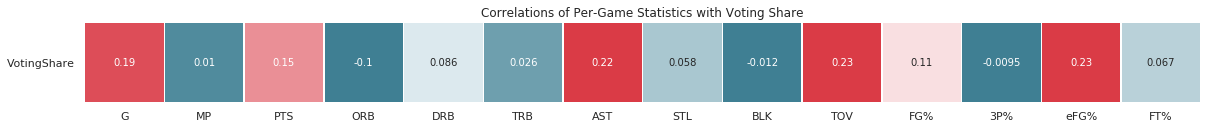

In [17]:
cmap = sns.diverging_palette(220,10, as_cmap=True) # set color scheme
plt = hmap(pg.drop(columns=['Season', 'Tm', 'Rank', 'Name', 'Pos']), 
     ['G','MP','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%','eFG%','FT%'])
plt.title('Correlations of Per-Game Statistics with Voting Share')
plt.show()

Taking a close look at the results shows a more significant relationship (relative to other statistics) between voting share and MVP candidates' games played (G), assist contribution (AST), turnovers (TOV), and effective field goal percentage (eFG%). As discussed above, a high amount of turnovers is not a desirable statistic but is indicative of a valuable player as any player who has the basketball more than their teammates will likely lose the ball more often than other players.

For an explanation of effective field goal percentage, see [here](https://captaincalculator.com/sports/basketball/effective-field-goal-percentage-calculator/)

Our next heat map will display the correlations of team statistics and voting share.

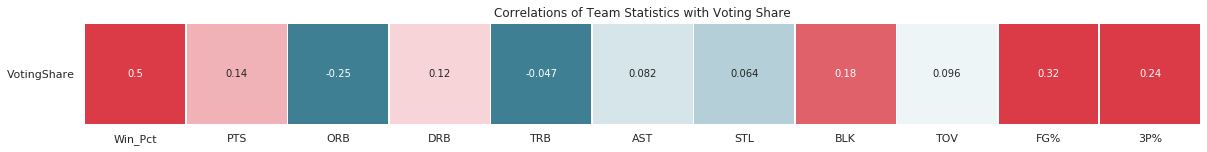

In [18]:
plt = hmap(tm.drop(columns=['Season', 'Tm', 'Rank', 'Name']), 
           ['Win_Pct','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%'])
plt.title('Correlations of Team Statistics with Voting Share')
plt.show()

We see that some of the more significant correlations between team statistics and voting share were the winning percentage (Win_Pct), blocks (BLK), field goal percentage (FG%), and three-point percentage (3P%).

Winning Percentage shows the highest correlation with voting share of any of our statistics which corresponds with the positive relationship displayed in the *MVP Teams' Winning Percentage vs. Voting Share* graph. This correlation makes sense as MVP voters are probably more likely to vote for a player on a good team than one on a bad team.

The final heat map shows correlations between MVP contribution statistics and voting share.

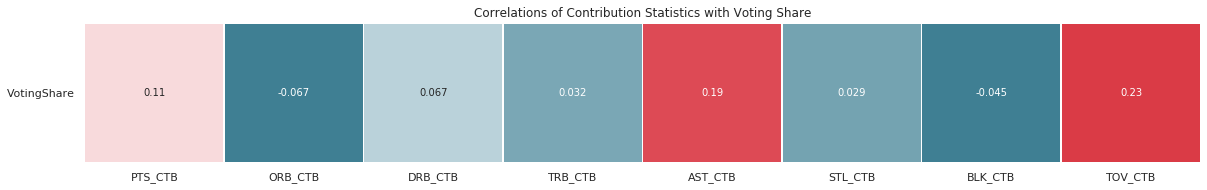

In [19]:
plt = hmap(ctb.drop(columns=['Season', 'Tm', 'Rank', 'Name']), 
           ['PTS_CTB','ORB_CTB','DRB_CTB','TRB_CTB','AST_CTB','STL_CTB','BLK_CTB','TOV_CTB'])
plt.title('Correlations of Contribution Statistics with Voting Share')
plt.show()

The most significant correlations found were assist contribution (AST_CTB), and turnover contribution (TOV_CTB). As noted above, turnovers typically signify a player with a high usage rate so a higher correlation between turnover contribution and voting share is likely an indication of a valuable player.

### Creating a Model
---
Now that we have visualized our data and found relationships between the statistics and MVP voting share, we will begin the process of modeling MVP voting share.

First, we declare several functions to assist us in creating our model.

In [20]:
# This function takes three dataframe and a list of selected columns and concatenates the columns into one 
# dataframe
def select(pg, tm, ctb, lists):
    pg_select = pg.copy(deep=True)[lists[0]]
    tm_select = tm.copy(deep=True)[lists[1]]
    ctb_select = ctb.copy(deep=True)[lists[2]]
    return pd.concat([pg_select, tm_select, ctb_select], axis=1)

# This function takes a list of x-values and a list of residuals and plots the residuals of each x-value
def rsd_plot(x, rsd):
    plt.figure(figsize=(20,10))
    sns.violinplot(x=x,y=rsd)
    plt.title('Residuals vs. MVP Rank', fontweight="bold", fontsize=20)
    plt.xlabel('MVP Rank')
    plt.ylabel('Residual')
    plt.show()

# This function takes a player, their team, the year, a regression model, and a list of columns
# Data is collected on the player and their team's statistics for the given season, then their contribution
# statistics are calculated. Next, the statistics are combined into one dataframe and run through the regression
# model
# Returns the predicted voting share for a player
def predict(name, team_name, year, reg, lists):
    pergame = pd.DataFrame()
    team = pd.DataFrame()
    (pergame, team) = collect([name], [team_name], year, pergame, team) 
    ctb = pd.DataFrame()
    ctb['Season'] = pergame['Season']
    ctb['Tm'] = pergame['Tm']
    for col in ['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV']:
        ctb[str(col+'_CTB')] = pergame[col]/tm[col]
    ctb['Name'] = pergame['Name']
    data = select(pergame, team, ctb, lists)
    return reg.predict(data)[0]

In order to create as accurate a model as possible, we will first select the statistics that the model will be based upon. For per-game statistics, we chose games played (G), points (PTS), assists (AST), effective field goal percentage (eFG%), and free throw percentage (FT%) as they had the highest correlations. Similarly, for team statistics we chose winning percentage (Win_Pct), field goal percentage (FG%), and three point percentage (3P%). Finally, for contributions statistics we chose assist contributions (AST_CTB) and turnover contributions (TOV_CTB).

Then, we used the Scikit-Learn function GridSearchCV() to find the best parameters for a linear model of our data. After this, we used train_test_split() to split our data set into training and testing data so that we could fit our model using the training data and compare our model's results with our testing data.

To visually represent how well the model fits, we then displayed a violion plot of the residuals for each of the MVP ranks.

For more information on GridSearch, see [here](https://www.datatechnotes.com/2019/09/how-to-use-gridsearchcv-in-python.html)

For more information on the train_test_split() function and why it is used, see [here](https://pythonbasics.org/split-train-test/)

R-squared: 0.429758472399729


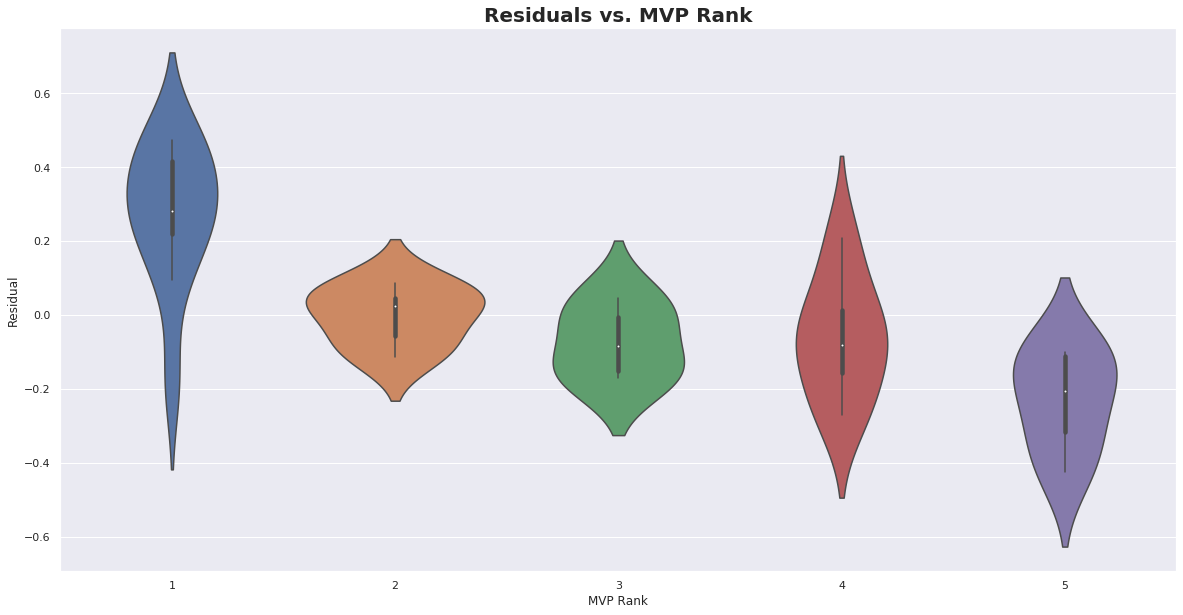

In [21]:
# Select the columns of desired statistics for the model
pg_list = ['Rank', 'G', 'PTS', 'AST', 'eFG%', 'FT%']
tm_list = ['Win_Pct', 'FG%', '3P%']
ctb_list = ['AST_CTB', 'TOV_CTB']
lists = [pg_list, tm_list, ctb_list]
X = select(pg, tm, ctb, lists)
y = pg['VotingShare']

# perform gridsearch to find the best parameters for the model
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
gridsearch = GridSearchCV(estimator=linear_model.LinearRegression(), param_grid=parameters, cv=5, iid=False, 
                         return_train_score=True)
gridsearch.fit(X, y)

# generate training and testing data from our dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train = X_train.drop(columns=['Rank'])
lin_reg = gridsearch.best_estimator_ # get the best estimator from the gridsearch
lin_reg.fit(X_train, y_train) # fit the model to the training data
# generate predicted voting shares based on the testing data
y_pred = lin_reg.predict(X_test.drop(columns=['Rank'])) # drop rank as it is not a feature, but is used in plots
while r2_score(y_test, y_pred) < .4: # retrain the model if needed (sometimes training data is not ideal)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    X_train = X_train.drop(columns=['Rank'])
    lin_reg = GridSearchCV(estimator=linear_model.LinearRegression(), param_grid=parameters, cv=5, iid=False)
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test.drop(columns=['Rank']))
print('R-squared: ' + str(r2_score(y_test, y_pred))) # display R-squared value of the model
rsd_plot(X_test['Rank'], y_test - y_pred) # display residuals

With our R-squared value, we have created a model that has a moderate coefficient of determination between our variables and voting share.

Additionally, the residuals plot shows that the residuals for each rank are not all centered around zero or normally distributed, but the fact that the model overestimates higher ranked MVP candidates and underestimates lower ranked MVP candidates is not entirely disqualifying.

So, we have created an imperfect model for MVP voting share, now lets see how well it can predict the MVP.

### Testing the Model
---
Before we test our model, we will first declare several functions to assist us.

In [25]:
# This function takes a year and a cutoff value and returns a list of players from that year who played more games
# than the cutoff value
def rosters(year, cutoff):
    tables = pd.read_html('https://basketball.realgm.com/nba/players/' + str(year))
    table = tables[12].copy(deep=True)[tables[12]['GP'] >= cutoff]
    j = 0
    for i, x in table.iterrows(): # remove any players that were traded during the season
        if len(x['Teams']) > 3:
            table.drop(table.index[j], inplace=True)
            j -= 1
        j += 1
    return table[['Player', 'Teams']]

# This function takes a list of player, a year, a regression model, and a list of variables and returns a table
# of predicted voting shares for each player
def generate_predictions(players, year, reg, lists):
    predictions = pd.DataFrame()
    for (name, team) in zip(players['Player'], players['Teams']): # iterate through all players and their teams
        try:
            prediction = predict(name, team, year, lin_reg, lists) # predict voting share for player
        except:
            continue # ignore failed predictions (usually a result of mispelled player names from realGM)
        predictions = predictions.append(pd.DataFrame([[name, prediction]], columns=['Player', 
                        'Predicted VotingShare']), sort=False).reset_index()[['Player', 'Predicted VotingShare']]
    predictions.to_csv(str(year) + '_Predictions.csv')

Now, we will scrape [realGM](https://basketball.realgm.com/) for a list of players that played more than 65 games in the 2018-19 NBA season (to keep the dataset at a manageable size) and then we will generated predicted voting share values for each player. Finally, we will show the model's predicted top 5 MVP candidates.

In [32]:
# remove the Rank column from the list as it is not in the players dataframe
pg_list = ['G', 'PTS', 'AST', 'eFG%', 'FT%'] 
lists = [pg_list, tm_list, ctb_list]
if not os.path.isfile('2019_Predictions.csv'):
    players = rosters(2019, 65) #collect list of all players from the 2018-19 season with more than 65 games played
    generate_predictions(players, 2019, lin_reg, lists) 
predictions = pd.read_csv('2019_Predictions.csv').drop(columns=['Unnamed: 0'])
predictions.sort_values(by='Predicted VotingShare', ascending=False, inplace=True)
predictions.reset_index(drop=True, inplace=True)
predictions.head(5)

Player  Predicted VotingShare
0           James Harden               0.677368
1  Giannis Antetokounmpo               0.646215
2           Kevin Durant               0.516136
3          Stephen Curry               0.486245
4         Damian Lillard               0.397459

Let's take a look at the actual top five MVP candidates from the 2018-19 season to compare.

In [27]:
votes_df[votes_df['Year'] == 2019][['Rank', 'Player', 'VotingShare']]

Rank                 Player  VotingShare
0     1  Giannis Antetokounmpo        0.932
1     2           James Harden        0.768
2     3            Paul George        0.352
3     4           Nikola Jokić        0.210
4     5          Stephen Curry        0.173

If we compare these two tables, we can see that our model is not too far off in terms of the top MVP candidates, although several players are overrated or underrated in terms of their predicted voting shares.

Next, we will use our model to predict the 2019-20 NBA MVP. At the time of writing, the 2019-20 NBA regular season is less than a third of the way complete, so predictions will be based on the data currently available.

In [33]:
if not os.path.isfile('2020_Predictions.csv'):
    # Due to realGM writing out the full team name for the current season while basketball-reference uses an 
    # abbreviation for each team, we have a dictionary that will take a full team name and convert it to an 
    # abbreviated form
    team_codes = {'Atlanta Hawks': 'ATL','Boston Celtics': 'BOS','Brooklyn Nets': 'BRK','Chicago Bulls': 'CHI',
                  'Charlotte Hornets': 'CHO','Cleveland Cavaliers': 'CLE','Dallas Mavericks': 'DAL',
                  'Denver Nuggets': 'DEN','Detroit Pistons': 'DET','Golden State Warriors': 'GSW',
                  'Houston Rockets': 'HOU','Indiana Pacers': 'IND','Los Angeles Clippers': 'LAC',
                  'Los Angeles Lakers': 'LAL','Memphis Grizzlies': 'MEM','Miami Heat': 'MIA',
                  'Milwaukee Bucks': 'MIL','Minnesota Timberwolves': 'MIN','New Orleans Pelicans': 'NOP',
                  'New York Knicks': 'NYK','Oklahoma City Thunder': 'OKC','Orlando Magic': 'ORL',
                  'Philadelphia Sixers': 'PHI','Phoenix Suns': 'PHO','Portland Trail Blazers': 'POR',
                  'Sacramento Kings': 'SAC','San Antonio Spurs': 'SAS','Toronto Raptors': 'TOR','Utah Jazz': 'UTA',
                  'Washington Wizards': 'WAS'}
    # Another problem with the realGM dataset for the current season is no statistics on games played so there is no
    # way to trim down the players list, so we instead took the list of players from the season before with more than
    # 55 games played and then used that to create the list of players for the current season
    players = rosters(2019, 55) # collect list of all players from the 2018-19 season with more than 55 games played
    tables = pd.read_html('https://basketball.realgm.com/nba/players/2020')
    teams = tables[12].copy(deep=True)[['Player','Current Team']]
    teams.loc[:,'Current Team'] = [team_codes[x] for x in teams['Current Team']] #replace team names with abbreviations
    for i, name in players['Player'].items():
        for name2, team in zip(teams['Player'],teams['Current Team']):
            if name == name2:
                players.loc[:,'Teams'][i] = team # assign any player that moved their new team
    generate_predictions(players, 2020, lin_reg, lists) 
predictions = pd.read_csv('2020_Predictions.csv').drop(columns=['Unnamed: 0'])
predictions.sort_values(by='Predicted VotingShare', ascending=False, inplace=True)
predictions.reset_index(drop=True, inplace=True)
predictions.head(5)

Player  Predicted VotingShare
0  Giannis Antetokounmpo               0.786719
1           LeBron James               0.739275
2          Anthony Davis               0.488358
3           James Harden               0.442040
4            Luka Doncic               0.346965

The model predicts that the 2019-20 NBA MVP will be {{predictions['Player'][0]}}!

## Conclusions
---
Now that we have tested our model, we can look back on the process and see where improvements could be made in the future. 

In the data collection and processing steps, it might have been helpful to obtain alternative data such as per 36 or per 100 statistics that normalize player statistics based on minutes played or possessions per game, respectively. Additionally, advanced data could have been obtained but as it serves a similar purpose to the model that the we built of aggregrating statistics together, this might have caused issues. Another problem encountered later in the process was small sample sizes, so expanding our data collection to include more seasons and/or more MVP candidates could have helped with this issue.

In the exploratory data analysis step, we displayed several trends in data that were relevant to the model, but the position data we obtained was not able to be used in our regression model, so we could have found a way to incorporate player position as a feature in the model.

In the model creation step, we constructed a model based on a set of variables determined using the regression plots and correlation heat maps in the previous step. However, the resulting model seemed to be highly influenced by some statistics more than others such as a higher team winning percentage. Changing the variables or using a different regressor may have helped us to fit a better model to our data.

If you have found this tutorial to be interesting, then perhaps you could attempt some of these improvements and build an even better model in the future.